# Malloggi-Vigna SEAI Project - Project Test Base



In [18]:
!nvcc  --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Mar_28_02:18:24_PDT_2024
Cuda compilation tools, release 12.4, V12.4.131
Build cuda_12.4.r12.4/compiler.34097967_0


/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## Colab (ONLY) Environment Setup

reference:
https://keras.io/getting_started/

Aim of this project:
- Keras 3
- Tensorflow 2.16.1 (only one compatible with Keras3)

Colab preinstalled packages:
- Keras 2
- Tensorflow 2.15.0
- tf-keras 2.15.1 (previous keras version which was defined as tensorflow sub-package)

Therefore we need to update Tensorflow to the latest version available.


---
reference: https://github.com/keras-team/tf-keras

TF-Keras: the pure-TensorFlow implementation of Keras
This repository hosts the development of the TF-Keras library. It is a pure TensorFlow implementation of Keras, based on the legacy tf.keras codebase.

Note that the "main" version of Keras is now Keras 3 (formerly Keras Core), which is a multi-backend implementation of Keras, supporting JAX, PyTorch, and TensorFlow. Keras 3 is being developed at keras-team/keras.

In [19]:
# tensorflow 2.15.0 is already installed, it must be uninstalled first
!pip uninstall tensorflow -y
!pip uninstall keras -y
!pip uninstall tf-keras -y
!pip install tensorflow
# !pip install --upgrade keras //automatically done installing tensorflow

Found existing installation: tensorflow 2.16.1
Uninstalling tensorflow-2.16.1:
  Successfully uninstalled tensorflow-2.16.1
Found existing installation: keras 3.3.3
Uninstalling keras-3.3.3:
  Successfully uninstalled keras-3.3.3
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━ 422.8/589.8 MB 6.4 MB/s eta 0:00:26^C
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━ 422.9/589.8 MB 6.4 MB/s eta 0:00:26
ERROR: Operation cancelled by user

[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python3 -m pip install --upgrade pip


# KERAS 3 - Multi-backend High-level API
Keras is the high-level API of the TensorFlow platform. It provides an approachable, highly-productive interface for solving machine learning (ML) problems, with a focus on modern deep learning.

## Backend instantiation
Remember to configure the backend before importing Keras (and the other modules), as the backend cannot be changed once the package is imported.

In [1]:
# Available backend options are: "jax", "tensorflow", "torch".
import os
os.environ["KERAS_BACKEND"] = "jax"

# Suppress all warnings and only show errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

## frameworks version

In [2]:
import sys
import tensorflow as tf
import jax
import jaxlib
import keras
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms
from jax import numpy as jnp

print(f"python3: {sys.version}")
print(f"tensorflow: {tf.__version__}")
print(f"jax: {jax.__version__}")
print(f"keras: {keras.__version__}")
print(f"numpy: {np.__version__}")
print(f"torch: {torch.__version__}")
print(f"torchvision: {torchvision.__version__}")
print(f"CUDA: {torch.version.cuda}")

cudnn = torch.backends.cudnn.version()
cudnn_major = cudnn // 1000
cudnn = cudnn % 1000
cudnn_minor = cudnn // 100
cudnn_patch = cudnn % 100
print( 'cuDNN:', '.'.join([str(cudnn_major),str(cudnn_minor),str(cudnn_patch)]) )

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

python3: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
tensorflow: 2.16.1
jax: 0.4.27
keras: 3.3.3
numpy: 1.26.3
torch: 2.3.0+cu118
torchvision: 0.18.0+cu118
CUDA: 11.8
cuDNN: 8.9.7


## Exclusive CPU Execution
uncomment the following command to force a CPU-ONLY processing.

In [3]:
# Hide GPU from visible devices (force CPU-ONLY processing)
#os.environ['CUDA_VISIBLE_DEVICES'] = ''

## Test GPU support

In [4]:
from tensorflow.python.client import device_lib

print('Tensorflow runs on device: ')
gpus = tf.config.list_physical_devices('GPU')
print('\t',[d.name for d in gpus])

Tensorflow runs on device: 
	 ['/physical_device:GPU:0']


In [5]:
print('Pytorch runs on device:', device)

#Additional Info when using cuda
if device.type == 'cuda':
    print('\t',torch.cuda.get_device_name(0))
    print('\t','Currently Memory Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('\t','Currently Memory Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Pytorch runs on device: cuda
	 NVIDIA GeForce RTX 3070 Laptop GPU
	 Currently Memory Allocated: 0.0 GB
	 Currently Memory Cached:    0.0 GB


In [6]:
print('JAX runs on device: \n\t',jax.local_devices())

JAX runs on device: 
	 [cuda(id=0)]


# Code To Test: LeNet-5 Architecture (CNN)


---


## Overall Frameworks Hyperparameters

In [7]:
#Input data:
input_shape = (28, 28, 1)
IMG_SIZE = 28
num_classes = 10
train_dataset_size = 60000
test_dataset_size = 10000

train_batch_size = 1024
epochs = 50
learn_rate = 0.005
validation_split = 0.2

valid_batch_size = 1024
test_batch_size = 1024

### Results and Statistics Plotting Functions

In [8]:
import time
from matplotlib import pyplot as plt

def accuracy_plot(train_acc_history, valid_acc_history, test_acc, model, backend=None):
    if backend:
        model += ' (backend: ' + backend + ')'
    
    # Find the epoch with the highest validation accuracy
    max_val_epoch = np.argmax(valid_acc_history) + 1
    max_val_acc = valid_acc_history[max_val_epoch - 1]

    # Visualizing the training and validation accuracy
    plt.title(f'{model} model: Training and Validation Accuracy')
    plt.plot(train_acc_history, 'g-', label='Train Accuracy')
    plt.plot(valid_acc_history, 'b-', label='Val Accuracy')
    # Highlight the maximum validation accuracy
    plt.scatter(max_val_epoch, max_val_acc, color='black', s=100, zorder=5, label='Max Val Accuracy')
    plt.annotate(f'({max_val_epoch}, {max_val_acc:.2f})', 
                 (max_val_epoch, max_val_acc), 
                 textcoords="offset points", 
                 xytext=(10,-10), 
                 ha='center', 
                 fontsize=12, 
                 color='black')
    
    # Highlight the test accuracy
    plt.scatter(epochs, test_acc, color='red', s=100, zorder=5, label='Test Accuracy')
    plt.annotate(f'({epochs}, {test_acc:.2f})', 
                 (epochs, test_acc), 
                 textcoords="offset points", 
                 xytext=(10,-10), 
                 ha='center', 
                 fontsize=12, 
                 color='red')
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def print_statistics(start_time, end_time, test_acc, test_loss, model, backend=None):
    if backend:
        model += ' (backend: ' + backend + ')'
    print(f'{model} model ')
    print(f'\t train batch size:     {train_batch_size}')
    print(f'\t number of epochs:     {epochs}')
    print(f'\t learning rate:        {learn_rate}')
    print(f'\t validation split:     {validation_split}')
    print(f'\t total training time:  {end_time-start_time:.3f}')
    print(f'\t test accuracy:        {test_acc:.3f}')
    print(f'\t test loss:            {test_loss:3f}')

## Preprocessing: Fashion MNIST Dataset

In [9]:
from sklearn.model_selection import train_test_split
import keras.utils

#Keras - Getting and Splitting the Dataset
fashion_mnist = keras.datasets.fashion_mnist
#TensorFlow - Loading the Data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=validation_split, random_state=42 )


In [10]:
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_valid.shape[0], "valid samples")
print(x_test.shape[0], "test samples")

x_train shape: (48000, 28, 28, 1)
48000 train samples
12000 valid samples
10000 test samples


## PyTorch LeNet-5 Architecture (CNN)

reference: https://medium.com/@soumensardarintmain/manage-cuda-cores-ultimate-memory-management-strategy-with-pytorch-2bed30cab1#:~:text=The%20recommended%20way%20is%20to,first%20and%20then%20call%20torch.

In [9]:
# Pytorch - loaders
tensor_x_train = torch.Tensor(x_train).squeeze(-1).unsqueeze(1)
tensor_y_train = torch.Tensor(y_train).type(torch.FloatTensor)

tensor_x_valid = torch.Tensor(x_valid).squeeze(-1).unsqueeze(1)
tensor_y_valid = torch.Tensor(y_valid).type(torch.FloatTensor)

tensor_x_test = torch.Tensor(x_test).squeeze(-1).unsqueeze(1)
tensor_y_test = torch.Tensor(y_test).type(torch.FloatTensor)

train_dataset_pt = torch.utils.data.TensorDataset(tensor_x_train, tensor_y_train)
train_loader_pt = torch.utils.data.DataLoader(dataset=train_dataset_pt,
                                              batch_size=train_batch_size,
                                              shuffle=True)
valid_dataset_pt = torch.utils.data.TensorDataset(tensor_x_valid,tensor_y_valid) 
valid_loader_pt = torch.utils.data.DataLoader(dataset=valid_dataset_pt,
                                              batch_size=valid_batch_size, 
                                              shuffle=False)
test_dataset_pt = torch.utils.data.TensorDataset(tensor_x_test,tensor_y_test) 
test_loader_pt = torch.utils.data.DataLoader(dataset=test_dataset_pt, 
                                             batch_size=test_batch_size, 
                                             shuffle=False)

In [10]:
#Pytorch - Building the Model
model_pt = nn.Sequential(
    # Layer1 = Conv1
    nn.Conv2d(1, 6, (5, 5), stride=1, padding=2),
    nn.ReLU(),
    nn.AvgPool2d((2, 2), stride=2),

    # Layer2 = Conv2
    nn.Conv2d(6, 16, (5, 5), stride=1, padding=2),
    nn.ReLU(),
    nn.AvgPool2d((2, 2), stride=2),

    nn.Flatten(),
    # Layer3 = Conv3
    nn.Linear(784,120),
    nn.ReLU(),
    nn.Linear(120,84),
    nn.ReLU(),
    nn.Linear(84,10)
)
model_pt.to(device)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU()
  (5): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=784, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

PyTorch model 
	 train batch size:     1024
	 number of epochs:     50
	 learning rate:        0.005
	 validation split:     0.2
	 total training time:  33.993
	 test accuracy:        0.900
	 test loss:            0.371071


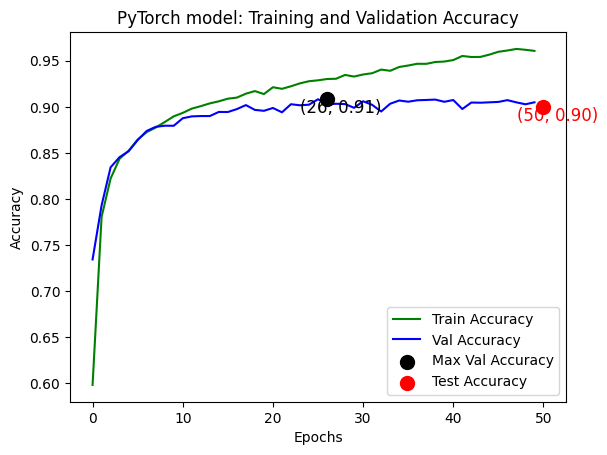

In [11]:
#Pytorch - Training the Model
import statistics as stats

criterion_pt = nn.CrossEntropyLoss()
optimizer_pt = torch.optim.Adam(model_pt.parameters(),lr=learn_rate)


def model_pt_forward_pass(images, labels, model, criterion, optimizer=None):
    images = images.to(device)
    labels = labels.to(device)
    if optimizer:
        optimizer.zero_grad()
    out = model_pt(images)
    loss = criterion(out, labels)
    # backward pass for training (optimizer exists)
    if optimizer:
        loss.backward()
        optimizer.step()
    # Compute statistics
    _, predicted = torch.max(out, 1)
    _, actual = torch.max(labels, 1)
    correct_predictions = (predicted == actual).sum().item()
    accuracy = correct_predictions / labels.shape[0]
    return loss, accuracy


def model_pt_training(loader, model, criterion, optimizer):
    model_pt.train()
    accuracy_list = []
    loss_list = []
    # loop over batch (same epoch)
    for images, labels in loader:    
        batch_loss, batch_accuracy = model_pt_forward_pass(images, labels, model, criterion, optimizer)
        accuracy_list.append(batch_accuracy)
        loss_list.append(batch_loss)
    return accuracy_list, loss_list
        

def model_pt_evaluation(loader, model, criterion):
    model_pt.eval()
    accuracy_list = []
    loss_list = []
    with torch.no_grad():
        # loop over batch (same epoch)
        for images, labels in loader:
            batch_loss, batch_accuracy = model_pt_forward_pass(images, labels, model, criterion)
            accuracy_list.append(batch_accuracy)
            loss_list.append(batch_loss)
    return accuracy_list, loss_list
    


train_acc_history = []
train_loss_history = []
valid_acc_history = []
valid_loss_history = []
test_acc = None
test_loss = None

start_time = time.time()
# Training and Validation Phase
# Loop over epochs
for e in range(epochs):

    # Training Step
    accuracy_list, loss_list = model_pt_training(train_loader_pt, model_pt, criterion_pt, optimizer_pt)
    train_acc_history.append(stats.fmean(accuracy_list))
    train_loss_history.append(stats.fmean(loss_list))
    
    # Validation Step
    accuracy_list, loss_list = model_pt_evaluation(valid_loader_pt, model_pt, criterion_pt)
    valid_acc_history.append(stats.fmean(accuracy_list))
    valid_loss_history.append(stats.fmean(loss_list))

end_time = time.time()

#Pytorch - Testing the Model
accuracy_list, loss_list = model_pt_evaluation(test_loader_pt, model_pt, criterion_pt)
test_acc = stats.fmean(accuracy_list)
test_loss = stats.fmean(loss_list)

# Printing Results
print_statistics(start_time, end_time, test_acc, test_loss, 'PyTorch')
accuracy_plot(train_acc_history, valid_acc_history, test_acc, 'PyTorch')

## Keras LeNet-5 Architecture (CNN)

In [9]:
# Keras Datasets
x_train_ks = x_train
y_train_ks = y_train
x_valid_ks = x_valid
y_valid_ks = y_valid
x_test_ks = x_test
y_test_ks = y_test


In [10]:
#Keras - Building the Model
model_ks = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Conv2D(6, kernel_size=(5, 5), strides=1, padding="same", activation="relu"),
        keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2),
        keras.layers.Conv2D(16, kernel_size=(5, 5), strides=1, padding="same", activation="relu"),
        keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2),
        keras.layers.Flatten(),
        keras.layers.Dense(120, activation="relu"),
        keras.layers.Dense(84, activation="relu"),
        keras.layers.Dense(num_classes, activation="softmax")
    ]
)
#Keras - Visualizing the Model
model_ks.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 7, 7, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │        94,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,786 (421.04 KB)

 Trainable params: 107,786 (421.04 KB)

 Non-trainable params: 0 (0.00 B)

Keras 3 (backend: jax) model 
	 train batch size:     1024
	 number of epochs:     50
	 learning rate:        0.005
	 validation split:     0.2
	 total training time:  26.574
	 test accuracy:        0.895
	 test loss:            0.300816


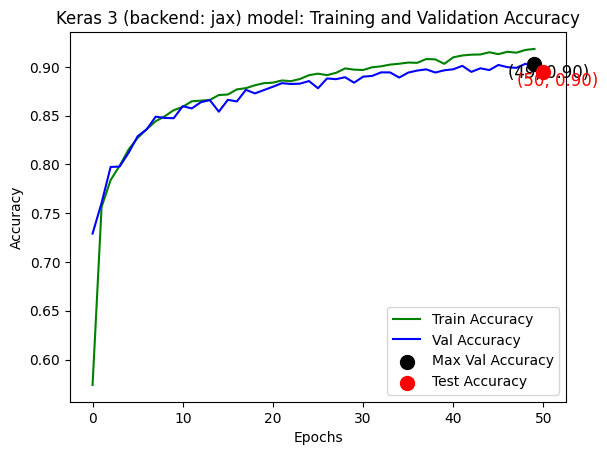

In [11]:
model_ks.compile(loss="categorical_crossentropy",
                    optimizer="adam",
                    metrics=["accuracy"])
#Keras - Training the Model
start_time = time.time()
results = model_ks.fit(x_train_ks, y_train_ks, batch_size=train_batch_size, epochs=epochs, validation_data=(x_valid_ks, y_valid_ks), shuffle=True, verbose=False)
end_time = time.time()

#Keras - Testing the Model
test_loss, test_acc = model_ks.evaluate(x_test_ks, y_test_ks, verbose=0)

# Printing Results
print_statistics(start_time, end_time, test_acc, test_loss, 'Keras 3', os.environ["KERAS_BACKEND"])
accuracy_plot(results.history['accuracy'], results.history['val_accuracy'], test_acc, 'Keras 3', os.environ["KERAS_BACKEND"])

## TensorFlow LeNet-5 Architecture (CNN)

In [9]:
#Tensorflow - Datasets
train_dataset_tf = tf.data.Dataset.from_tensor_slices((x_train, y_train))
valid_dataset_tf = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
test_dataset_tf = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_dataset_tf = train_dataset_tf.shuffle(buffer_size= x_train.shape[0], reshuffle_each_iteration=True).batch(train_batch_size)
valid_dataset_tf = valid_dataset_tf.batch(valid_batch_size)
test_dataset_tf = test_dataset_tf.batch(test_batch_size)

In [10]:
#Tensorflow - Building the Model
class Model_tf(tf.Module):
    def __init__(self, name="LeNet_model_tf"):
        super().__init__(name=name)

        # Variables definition
        self.conv1 = tf.Variable(tf.random.normal([5, 5, input_shape[-1], 6]), name='conv1')
        self.conv2 = tf.Variable(tf.random.normal([5, 5, 6, 16]), name='conv2')
        self.fc1 = tf.Variable(tf.random.normal([784, 120]), name='fc1')
        self.fc2 = tf.Variable(tf.random.normal([120, 84]), name='fc2')
        self.fc3 = tf.Variable(tf.random.normal([84, num_classes]), name='fc3')

        self.bias1 = tf.Variable(tf.zeros([6]), name='bias1')
        self.bias2 = tf.Variable(tf.zeros([16]), name='bias2')
        self.bias3 = tf.Variable(tf.zeros([120]), name='bias3')
        self.bias4 = tf.Variable(tf.zeros([84]), name='bias4')
        self.bias5 = tf.Variable(tf.zeros([num_classes]), name='bias5')

    @tf.function
    def __call__(self, x):
        # 1st layer: Convolution
        x = tf.nn.conv2d(x, self.conv1, strides=[1, 1, 1, 1], padding='SAME')
        x = tf.nn.bias_add(x, self.bias1)
        x = tf.nn.relu(x)
        # 1st layer: Pooling
        x = tf.nn.avg_pool2d(x, ksize=2, strides=2, padding='SAME')

        # 2nd layer: Convolution
        x = tf.nn.conv2d(x, self.conv2, strides=[1, 1, 1, 1], padding='SAME')
        x = tf.nn.bias_add(x, self.bias2)
        x = tf.nn.relu(x)
        # 2nd layer: Pooling
        x = tf.nn.avg_pool2d(x, ksize=2, strides=2, padding='SAME')

        # flattening
        x = tf.reshape(x, [-1, 784])

        # 3rd layer: Dense
        x = tf.nn.relu(tf.add(tf.matmul(x, self.fc1), self.bias3))
        # 4th layer: Dense
        x = tf.nn.relu(tf.add(tf.matmul(x, self.fc2), self.bias4))
        # 5th layer: Dense
        x = tf.add(tf.matmul(x, self.fc3), self.bias5)
        return x

model_tf = Model_tf()

Tensorflow model 
	 train batch size:     1024
	 number of epochs:     50
	 learning rate:        0.005
	 validation split:     0.2
	 total training time:  27.522
	 test accuracy:        0.828
	 test loss:            16.397055


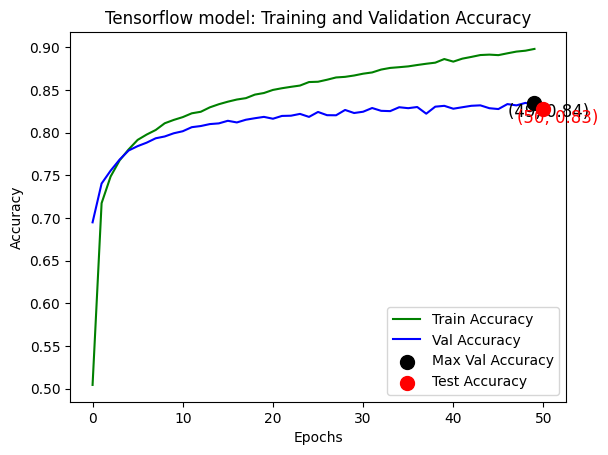

In [11]:
#Tensorflow - Training the Model
loss_fn = tf.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.optimizers.Adam(learning_rate = learn_rate)
 
 
@tf.function
def train_step(X, y):
    with tf.GradientTape() as tape:
        y_pred = model_tf(X)
        loss = loss_fn(y, y_pred)
    gradients = tape.gradient(loss, model_tf.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_tf.trainable_variables))
 
    # Calculate accuracy
    correct_predictions = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return loss, accuracy
 
 
def test_step(X, y):
    y_pred = model_tf(X)
    loss = loss_fn(y, y_pred)
 
    # Calculate accuracy
    correct_predictions = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return loss, accuracy
 
 
def model_tf_training():
    loss_list = []
    accuracy_list=[]
    # Loop over batches
    for batch_x, batch_y in train_dataset_tf:
        batch_loss, batch_accuracy = train_step(batch_x, batch_y)
        loss_list.append(batch_loss)
        accuracy_list.append(batch_accuracy)
    return loss_list, accuracy_list
 
 
def model_tf_evaluation(dataset):
    loss_list = []
    accuracy_list=[]
    # Loop over batches
    for batch_x, batch_y in dataset:
        batch_loss, batch_accuracy = test_step(batch_x, batch_y)
        loss_list.append(batch_loss)
        accuracy_list.append(batch_accuracy)
    return loss_list, accuracy_list
 
train_acc_history = []
train_loss_history = []
valid_acc_history = []
valid_loss_history = []
test_acc = None
test_loss = None

 
start_time = time.time()
# Training and Validation Phase
# Loop over epochs
for i in range(epochs):
    # Training Step
    loss_list, accuracy_list = model_tf_training()
    train_loss_history.append(tf.reduce_mean(loss_list))
    train_acc_history.append(tf.reduce_mean(accuracy_list))
 
    # Validation Step
    loss_list, accuracy_list = model_tf_evaluation(valid_dataset_tf)
    valid_loss_history.append(tf.reduce_mean(loss_list))
    valid_acc_history.append(tf.reduce_mean(accuracy_list))
end_time = time.time()
 
#Tensorflow - Testing the Model
loss_list, accuracy_list = model_tf_evaluation(test_dataset_tf)
test_loss = tf.reduce_mean(loss_list)
test_acc = tf.reduce_mean(accuracy_list)
 
# Printing Results
print_statistics(start_time, end_time, test_acc, test_loss, 'Tensorflow')
accuracy_plot(train_acc_history, valid_acc_history, test_acc, 'Tensorflow')

## Jax-Flax LeNet-5 Architecture (CNN)


reference:


https://github.com/8bitmp3/JAX-Flax-Tutorial-Image-Classification-with-Line

https://www.machinelearningnuggets.com/jax-cnn/

https://www.kaggle.com/code/sauravmaheshkar/image-classification-using-flax


!pip install --upgrade -q pip jax jaxlib flax optax tensorflow-datasets

In [11]:
#JAX-FLAX - further imports needed
import tensorflow_datasets as tfds
import pandas as pd
from jax import random
from jax import numpy as jnp
import optax
import flax
from flax import linen as nn
from flax.training import train_state

In [12]:
#JAX - Datasets
from sklearn.model_selection import train_test_split
import keras.utils

#Keras - Getting and Splitting the Dataset
fashion_mnist = keras.datasets.fashion_mnist
#TensorFlow - Loading the Data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

x_train = jnp.expand_dims(x_train, -1)
x_test = jnp.expand_dims(x_test, -1)

x_train, x_valid, y_train, y_valid = train_test_split(
x_train, y_train, test_size=validation_split, random_state=42 )

train_dataset_jax = tf.data.Dataset.from_tensor_slices((x_train, y_train))
valid_dataset_jax = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
test_dataset_jax = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_dataset_jax = train_dataset_jax.shuffle(buffer_size= x_train.shape[0], reshuffle_each_iteration=True).batch(train_batch_size)
valid_dataset_jax = valid_dataset_jax.batch(valid_batch_size)
test_dataset_jax = test_dataset_jax.batch(test_batch_size)

In [13]:
#JAX-FLAX - Building the Model
class Model_Flax(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=6, kernel_size=(5, 5), strides=(1, 1), padding='SAME')(x)
        x = nn.relu(x)
        
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding='VALID')
        x = nn.Conv(features=16, kernel_size=(5, 5), strides=(1, 1), padding='VALID')(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding='VALID')
        x = x.reshape((x.shape[0], -1))  # Flatten
        x = nn.Dense(features=120)(x)
        x = nn.relu(x)
        x = nn.Dense(features=84)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        return x

In [14]:
# JAX-FLAX - initializing the Model
rng = random.PRNGKey(0)
rng, init_rng = random.split(rng)

model = Model_Flax()
inp = jnp.ones([1, IMG_SIZE, IMG_SIZE, 1])

# Initialize the model
params = model.init(init_rng, inp)
model.apply(params, inp)

Array([[ 0.73247004,  0.26672053, -0.38702714,  0.7236394 ,  0.41028094,
        -0.11334093,  0.00428261, -0.16949001,  0.3927234 ,  0.5572688 ]],      dtype=float32)

Step 4: Training the Model

In [15]:
#JAX-FLAX - Defining the Training and Testing operations
#Definition of the optimizer and update the model state
optimizer = optax.adam(learning_rate=learn_rate) 
model_state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)


@jax.jit # Jit the function for efficiency
def train_step(state, images, labels):
    #Method use to calculate loss and accuracy
    def calculate_loss_acc(params, images, labels):
        # Obtain the logits and predictions of the model for the input data
        logits = state.apply_fn(params, images)
        # Calculate the loss and accuracy
        loss = jnp.mean(optax.softmax_cross_entropy(logits, jax.nn.one_hot(labels, num_classes)))
        # Multiclass classification
        acc = jnp.mean(jnp.argmax(logits, -1) == labels)
        return loss, acc

    # Gradient function & Determine gradients for current model, parameters and batch
    (loss, acc), grads = jax.value_and_grad(calculate_loss_acc, has_aux=True)(state.params, images, labels)
    # Perform parameter update with gradients and optimizer
    state = state.apply_gradients(grads=grads)
    return state, loss, acc


@jax.jit  # Jit the function for efficiency
def eval_step(state, images, labels):
    def calculate_loss_acc(params, images, labels):
        logits = state.apply_fn(params, images)
        loss = jnp.mean(optax.softmax_cross_entropy(logits, jax.nn.one_hot(labels, num_classes)))
        acc = jnp.mean(jnp.argmax(logits, -1) == labels)
        return loss, acc
    # Determine the accuracy
    loss, acc = calculate_loss_acc(state.params, images, labels)
    return loss, acc


train_acc_history = []
train_loss_history = []
valid_acc_history = []
valid_loss_history = []
test_acc = 0
test_loss = 0


def train_model(state, train_loader, valid_loader, num_epochs=30):
    # Training loop
    for epoch in range(num_epochs):
        train_batch_loss, train_batch_accuracy = [], []
        val_batch_loss, val_batch_accuracy = [], []

        for images, labels in train_loader:
            state, loss, acc = train_step(state, images, labels)
            train_batch_loss.append(loss)
            train_batch_accuracy.append(acc)

        for images, labels in valid_loader:
            val_loss, val_acc = eval_step(state, images, labels)

            val_batch_loss.append(val_loss)
            val_batch_accuracy.append(val_acc)

        # Loss for the current epoch
        epoch_train_loss = np.mean(train_batch_loss)
        epoch_val_loss = np.mean(val_batch_loss)

        # Accuracy for the current epoch
        epoch_train_acc = np.mean(train_batch_accuracy)
        epoch_val_acc = np.mean(val_batch_accuracy)

        valid_loss_history.append(epoch_val_loss)
        valid_acc_history.append(epoch_val_acc)

        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)
    return state

def evaluate_model(state, eval_loader):
    eval_losses, eval_accs = [], []
    for  images, labels in eval_loader:
        loss, acc = eval_step(state,  images, labels)
        eval_losses.append(loss)
        eval_accs.append(acc)
    mean_loss = np.mean(eval_losses)
    mean_acc = np.mean(eval_accs)
    return mean_loss, mean_acc
    

In [16]:
#JAX-FLAX - Training the Model
import time
start_time = time.time()
trained_model_state = train_model(model_state, tfds.as_numpy(train_dataset_jax), tfds.as_numpy(valid_dataset_jax), num_epochs=epochs)
end_time = time.time()

#JAX-FLAX - Testing the Model
test_loss, test_acc = evaluate_model(trained_model_state, tfds.as_numpy(test_dataset_jax))

JAX model 
	 train batch size:     1024
	 number of epochs:     50
	 learning rate:        0.005
	 validation split:     0.2
	 total training time:  22.859
	 test accuracy:        0.903
	 test loss:            0.371160


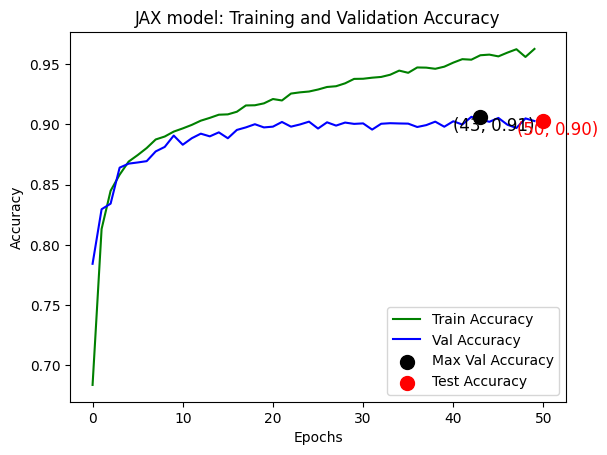

In [20]:
# Printing Results
print_statistics(start_time, end_time, test_acc, test_loss, 'JAX')
accuracy_plot(train_acc_history, valid_acc_history, test_acc, 'JAX')